# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

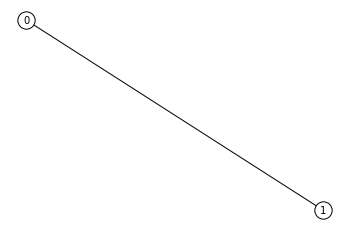

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}
Initial
max(J) = 2.0
max(h) = 1.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Rescaled
max(J) = 2.0
max(h) = 1.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Chain strength: 4.0
0
     0  1  2  3  chain_break_fraction  energy  num_occurrences
0    1  0  0  0                   0.0    -3.0                1
656  1  0  0  0                   0.0    -3.0                1
657  0  1  0  0                   0.0    -3.0                1
658  0  1  0  0                   0.0    -3.0                1
659  0  1  0  0                   0.0    -3.0                1


In [2]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
for nvertices in range(2,3):
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    print("Initial")
    print(f"max(J) = {maxJ}")
    print(f"max(h) = {maxh}")
    print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    print("Rescaled")
    print(f"max(J) = {maxJ}")
    print(f"max(h) = {maxh}")
    print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")

    # DWave settings
    dwave_config = {
        "annealing_time": 500,  # integer microseconds [1, 2000]
        "answer_mode": "raw", # histogram or raw
        "auto_scale": True,
        "num_reads": 1000,  # raw will dump out all results
        "num_spin_reversal_transforms": 0,
        "readout_thermalization": 0, # default 0
        "programming_thermalization": 1000, # default 1000
        "chain_strength": chain_strength
    }
    solver = "DW_2000Q_5"

    experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, qubo=qubo)


    # Solve on DWave and push to database
    sampler = DWaveSampler(solver=solver)
    embed = EmbeddingComposite(sampler)
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
    for idx in range(1):
        print(idx)
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        result = insert_result(graph_params, experiment_params, data_params)
    print(raw.sort_values("energy", ascending=True).head())

In [ ]:
#classical_search(qubo)

In [3]:
from qlpdb.data.models import Data as data_Data

In [5]:
data_Data.objects.filter(experiment__graph__tag="NN(2)").to_dataframe()

,id,last_modified,user,tag,experiment,measurement,spin_config,chain_break_fraction,energy,constraint_satisfaction
0,10000,2020-03-01 04:29:31.169811+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9999,"[1, 0, 0, 0]",0.0,1.0,True
1,9999,2020-03-01 04:29:31.140814+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9998,"[1, 0, 0, 0]",0.0,1.0,True
2,9998,2020-03-01 04:29:31.115349+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9997,"[0, 1, 0, 0]",0.0,1.0,True
3,9997,2020-03-01 04:29:31.086330+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9996,"[0, 1, 0, 0]",0.0,1.0,True
4,9996,2020-03-01 04:29:31.063795+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9995,"[0, 1, 0, 0]",0.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...
20995,80005,2020-03-01 05:18:19.652640+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",4,"[0, 1, 0, 0]",0.0,1.0,True
20996,80004,2020-03-01 05:18:19.631176+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",3,"[0, 1, 0, 0]",0.0,1.0,True
20997,80003,2020-03-01 05:18:19.608500+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",2,"[0, 1, 0, 0]",0.0,1.0,True
20998,80002,2020-03-01 05:18:19.589418+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",1,"[0, 1, 0, 0]",0.0,1.0,True
